# Project

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from joblib import dump, load
from os.path import exists

import matplotlib.pyplot as plt

## Data Exploration

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

# used ONLY for viewing data trends
viewFull = pd.concat([train_df, test_df], axis=0)

print("Train")
train_df.info()
print("Test")
test_df.info()

Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1

Looking at the data, here's what I found:

#### All Data
* PassengerId is uneccessary for training, so I'll drop it. **However, it is also used for submission so it will need to be readded later.**
* Name is uneccessary for training, so I'll drop it.
* Ticket has some really odd values, so I'll drop it for the time being, I'll add it later if I change my mind.

#### Train
We have some missing data cells from these features:
* Age - we only have 714/891 or 177 missing cells.
* Cabin - we only have 204/891 or 687 missing cells.
* Embarked - we only have 889/891 or 2 missing cells.

We will have to fill these missing cells later.

#### Test
We have some missing data cells from these features:
* Age - we only have 332/418 or 86 missing cells.
* Fare - we only have 417/418 or 1 missing cells.
* Cabin - we only have 91/418 or 327 missing cells.

We will have to fill these missing cells later.

Due to such a large amount of missing values for Cabin in both the training and test data, I will drop this feature.

#### Now lets see the distributions of each categorical feature and their effects on survivability in train_df.

### Pclass

Pclass
3    0.541635
1    0.246753
2    0.211612
Name: proportion, dtype: float64


<Axes: ylabel='Pclass'>

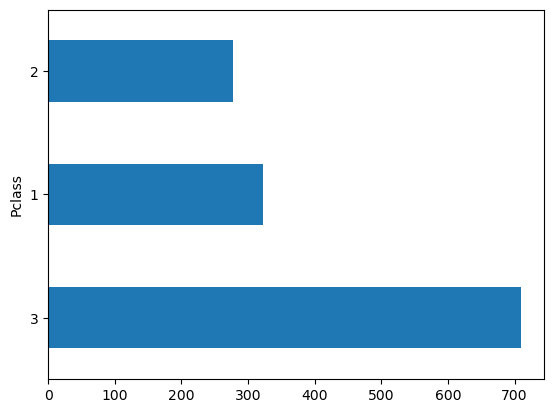

In [3]:
print(viewFull.Pclass.value_counts(normalize=True))
viewFull.Pclass.value_counts().plot.barh()

The distribution of the passengers' class is as follows:
* 54% were 3rd class
* 24% were 2nd class
* 21% were 1st class

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: proportion, dtype: float64


<Axes: xlabel='Pclass', ylabel='Survived'>

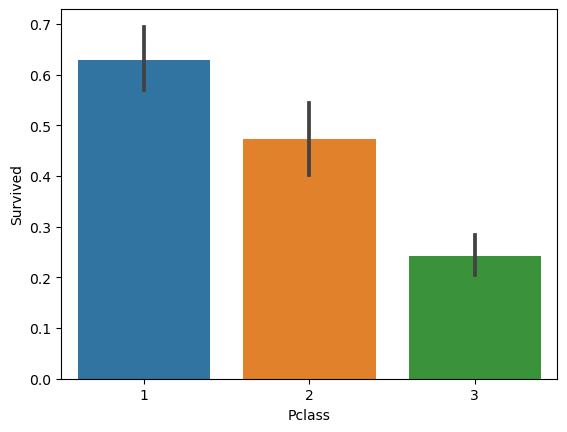

In [4]:
print(train_df.groupby("Pclass")["Survived"].value_counts(normalize=True))
sns.barplot(x="Pclass", y="Survived", data=train_df)

From the training data, we can see that:

* 24% of 3rd class passengers survived. This means there's a high likelihood that if the passenger is 3rd class, they won't survive.
* 52% of 2nd class passengers survived. Being a 2nd class passenger doesn't seem to be an indicator of survivability.
* 62% of 1st class passengers survived. This means there's a good likelihood that if the passenger is 1st class, they will survive.

### Sex

Sex
male      0.644003
female    0.355997
Name: proportion, dtype: float64


<Axes: ylabel='Sex'>

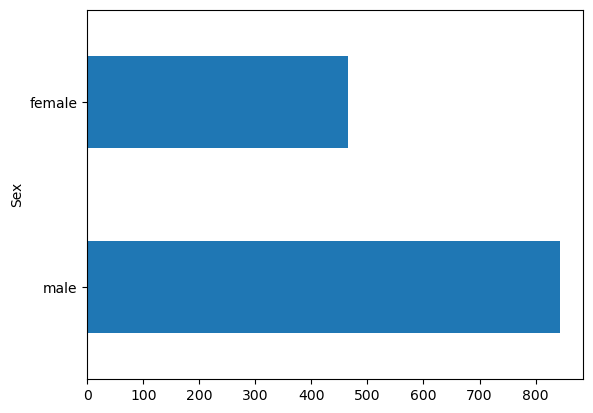

In [5]:
print(viewFull.Sex.value_counts(normalize=True))
viewFull.Sex.value_counts().plot.barh()

The distribution of the passengers' sex is as follows:
* 64% were male
* 35% were female

Sex     Survived
female  1           0.742038
        0           0.257962
male    0           0.811092
        1           0.188908
Name: proportion, dtype: float64


<Axes: xlabel='Sex', ylabel='Survived'>

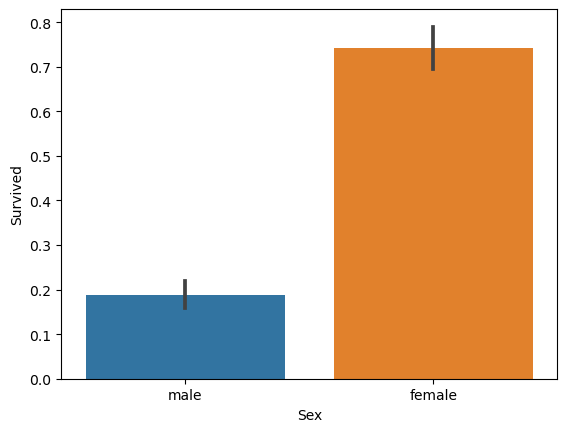

In [6]:
print(train_df.groupby("Sex")["Survived"].value_counts(normalize=True))

sns.barplot(x="Sex", y="Survived", data=train_df)

From the training data, we can see that:
* 74% of females survived. This means there's a high likelyhood that if the passenger is female, they will survive.
* 18% of males survived. This means there's a high likelyhood that if the passenger is male, they won't survive.

### Age

<Axes: ylabel='Frequency'>

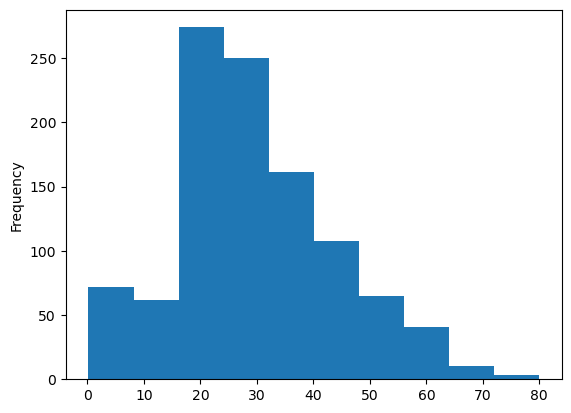

In [7]:
viewFull.Age.sort_values().plot.hist()

The distribution of the passengers' age is shown above (there's too many to list out individually).

<Axes: xlabel='Age', ylabel='Survived'>

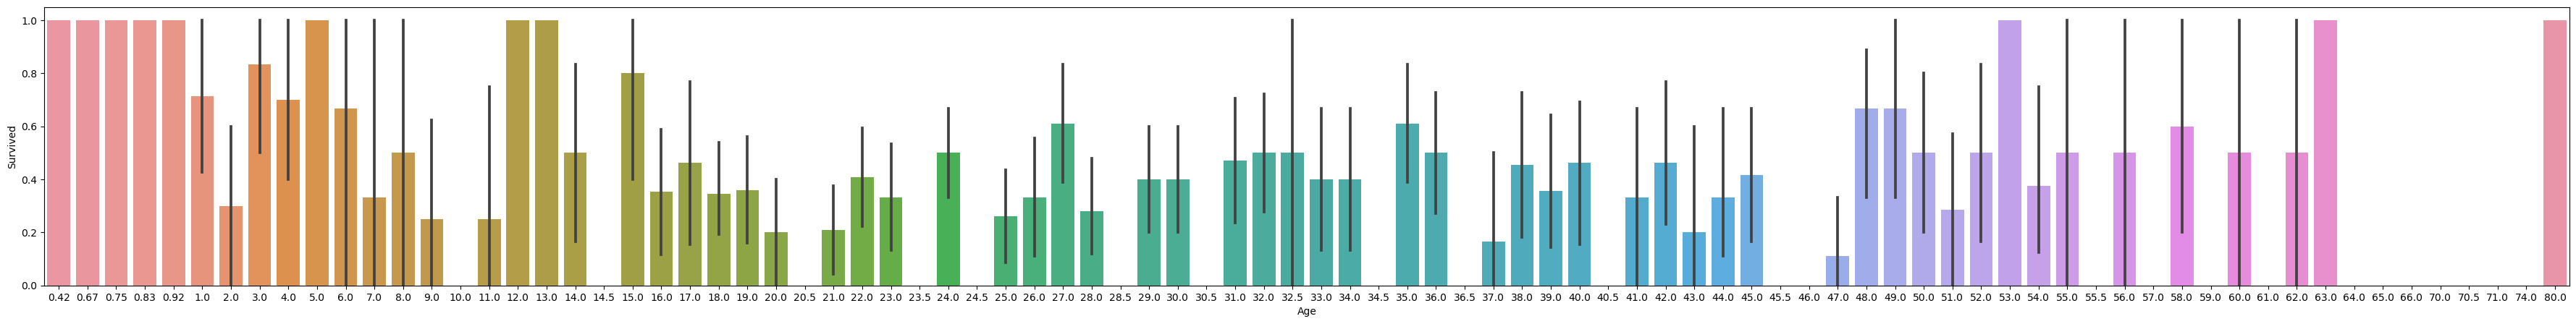

In [8]:
plt.figure(figsize=(45, 5))
sns.barplot(x="Age", y="Survived", data=train_df)

From the training data, we can see the distribution of survivability based on age. I can see generalized differences in survival based on age brackets so I'll add a feature that states whether a passenger is a child, adult, or an elder.

nf_Age
Adult    0.762906
Elder    0.127151
Child    0.109943
Name: proportion, dtype: float64


<Axes: ylabel='nf_Age'>

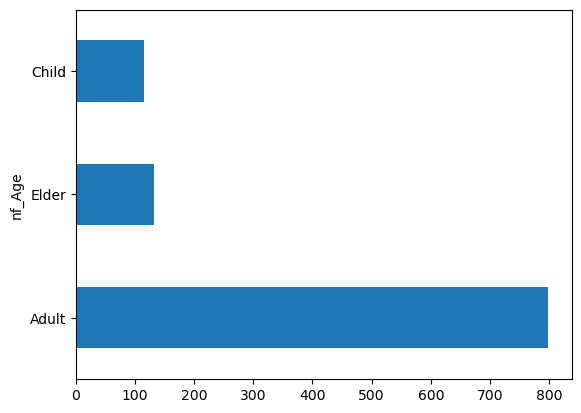

In [9]:
bins = [0, 16, 48, float('inf')]
labels = ['Child', 'Adult', 'Elder']

train_df['nf_Age'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)
test_df['nf_Age'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)
viewFull['nf_Age'] = pd.cut(viewFull['Age'], bins=bins, labels=labels, right=False)

print(viewFull.nf_Age.value_counts(normalize=True))
viewFull.nf_Age.value_counts().plot.barh()

The distribution of the passengers' age is as follows:
* 76% were between the ages of 16-47
* 12% were over the age of 47
* 10% were under the age of 16

nf_Age  Survived
Child   1           0.590361
        0           0.409639
Adult   0           0.623616
        1           0.376384
Elder   0           0.584270
        1           0.415730
Name: proportion, dtype: float64


<Axes: xlabel='nf_Age', ylabel='Survived'>

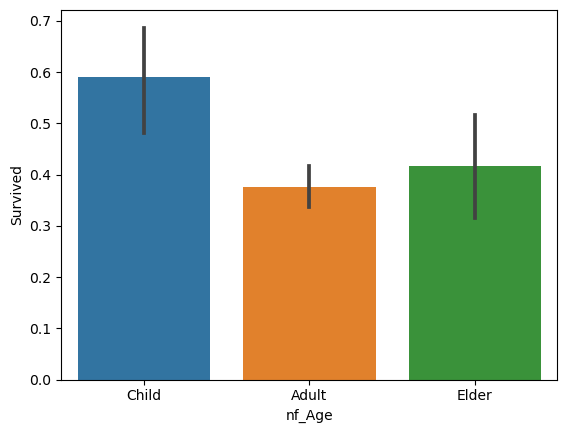

In [10]:
print(train_df.groupby("nf_Age")["Survived"].value_counts(normalize=True))
sns.barplot(x="nf_Age", y="Survived", data=train_df)

From the training data, we can see that:
* 59% of passengers under the age of 16 survived. This means there's a good likelihood that if the passenger is under the age of 16, they will survive.
* ~40% of the rest of the passengers survived. There's not much difference between the survivability of an adult and elder, so lets merge the two of them together and just call them adults.

In [11]:
bins = [0, 16, float('inf')]
labels = ['Child', 'Adult']

train_df['nf_Age'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)
test_df['nf_Age'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)
viewFull['nf_Age'] = pd.cut(viewFull['Age'], bins=bins, labels=labels, right=False)

### SibSp (Siblings/Spouses)

SibSp
0    0.680672
1    0.243697
2    0.032086
4    0.016807
3    0.015279
8    0.006875
5    0.004584
Name: proportion, dtype: float64


<Axes: ylabel='SibSp'>

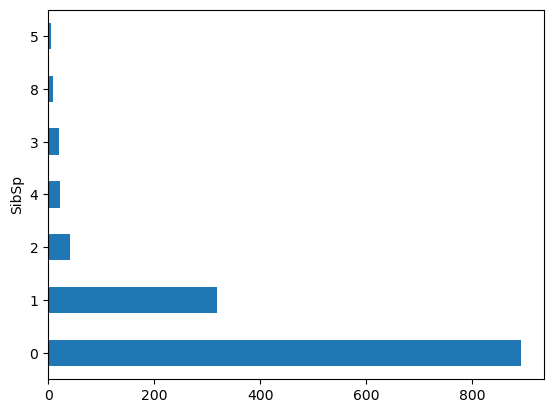

In [12]:
print(viewFull.SibSp.value_counts(normalize=True))
viewFull.SibSp.value_counts().plot.barh()

The distribution of passengers' with siblings or spouses (relations that aren't children/parent) onboard is as follows:
* 68% were by themselves
* 24% were with 1 other relation
* the rest had more than 1 other relation

SibSp  Survived
0      0           0.654605
       1           0.345395
1      1           0.535885
       0           0.464115
2      0           0.535714
       1           0.464286
3      0           0.750000
       1           0.250000
4      0           0.833333
       1           0.166667
5      0           1.000000
8      0           1.000000
Name: proportion, dtype: float64


<Axes: xlabel='SibSp', ylabel='Survived'>

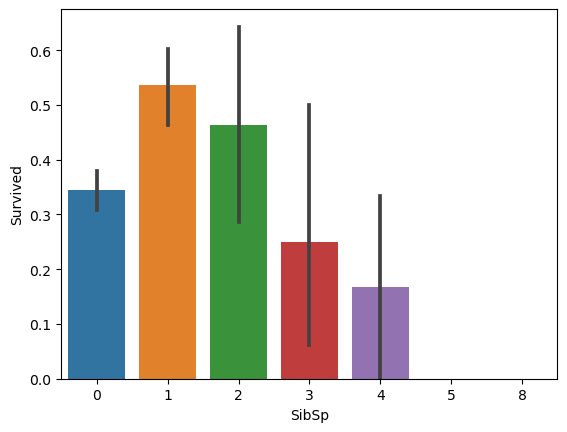

In [13]:
print(train_df.groupby("SibSp")["Survived"].value_counts(normalize=True))
sns.barplot(x="SibSp", y="Survived", data=train_df)

From the training data, we can see that:
* 34% of passengers that were by themselves survived.
* 53% of passengers that had 1 relation survived.
* 46% of passengers that had 2 relations survived.
* the passengers that had more than 2 relations had increasingly less likely chances of survival.

I'll add a feature that states whether a passenger is by themselves, has 1 or 2 relations, or has more relations.

nf_SibSp
0 Sib/Spouse         0.680672
1-2 Sib/Spouse       0.275783
Over 2 Sib/Spouse    0.043545
Name: proportion, dtype: float64


<Axes: ylabel='nf_SibSp'>

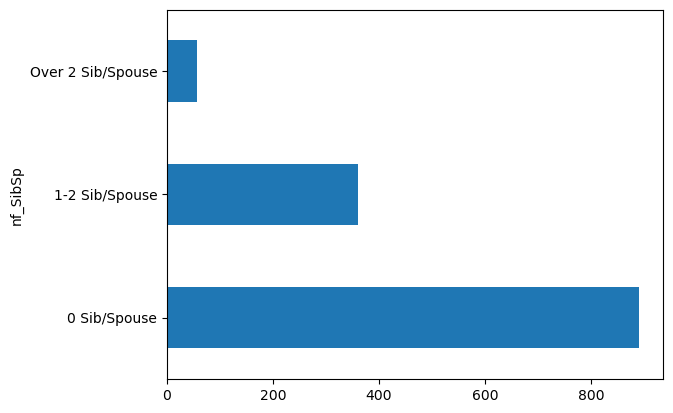

In [14]:
bins = [0, 1, 3, float('inf')]
labels = ['0 Sib/Spouse', '1-2 Sib/Spouse', 'Over 2 Sib/Spouse']

train_df['nf_SibSp'] = pd.cut(train_df['SibSp'], bins=bins, labels=labels, right=False)
test_df['nf_SibSp'] = pd.cut(test_df['SibSp'], bins=bins, labels=labels, right=False)
viewFull['nf_SibSp'] = pd.cut(viewFull['SibSp'], bins=bins, labels=labels, right=False)

print(viewFull.nf_SibSp.value_counts(normalize=True))
viewFull.nf_SibSp.value_counts().plot.barh()

nf_SibSp           Survived
0 Sib/Spouse       0           0.654605
                   1           0.345395
1-2 Sib/Spouse     1           0.527426
                   0           0.472574
Over 2 Sib/Spouse  0           0.847826
                   1           0.152174
Name: proportion, dtype: float64


<Axes: xlabel='nf_SibSp', ylabel='Survived'>

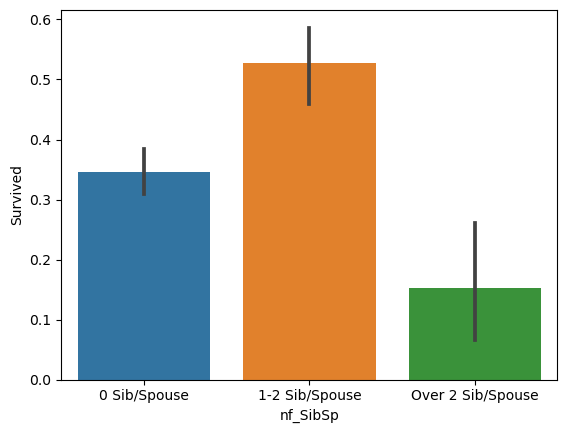

In [15]:
print(train_df.groupby("nf_SibSp")["Survived"].value_counts(normalize=True))
sns.barplot(x="nf_SibSp", y="Survived", data=train_df)

From the training data, we can see that:
* 34% of passengers that were by themselves survived. This means there is a high likelihood that if the passenger is by themselves, they won't survive.
* 52% of passengers that had 1 or 2 relations survived. A passenger having 1 or 2 relations doesn't seem to be an indicator of survivability on it's own. However due to all other options having lower survivabilities, you can say that these passengers have a higher likelihood of survivability.
* 15% of passengers that had more than 2 relations survived. This means there is an extemely high likelihood that if the passenger has more than 2 relations, they won't survive.

### Parch (Parents/Children)

Parch
0    0.765470
1    0.129870
2    0.086325
3    0.006112
5    0.004584
4    0.004584
6    0.001528
9    0.001528
Name: proportion, dtype: float64


<Axes: ylabel='Parch'>

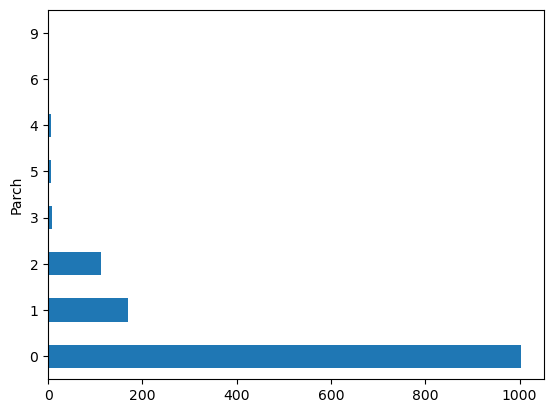

In [16]:
print(viewFull.Parch.value_counts(normalize=True))
viewFull.Parch.value_counts().plot.barh()

The distribution of passengers' with parents or children onboard is as follows:
* 76% were by themselves
* 12% had 1 relation
* 8% had 2 relations
* the rest had more than 2 relations

Parch  Survived
0      0           0.656342
       1           0.343658
1      1           0.550847
       0           0.449153
2      0           0.500000
       1           0.500000
3      1           0.600000
       0           0.400000
4      0           1.000000
5      0           0.800000
       1           0.200000
6      0           1.000000
Name: proportion, dtype: float64


<Axes: xlabel='Parch', ylabel='Survived'>

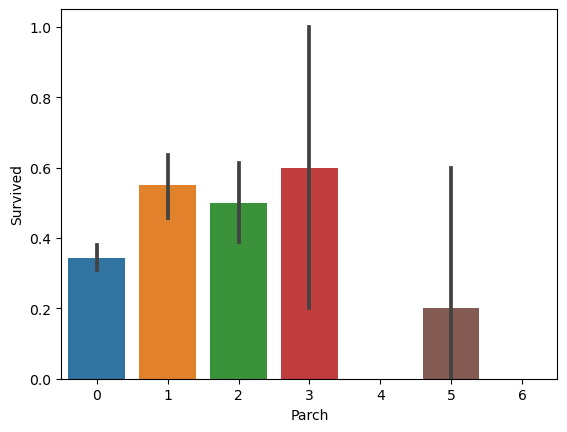

In [17]:
print(train_df.groupby("Parch")["Survived"].value_counts(normalize=True))
sns.barplot(x="Parch", y="Survived", data=train_df)

From the training data, we can see that:
* 34% of passengers that were by themselves survived.
* 55% of passengers that had 1 relation survived.
* 50% of passengers that had 2 relations survived.
* the passengers that had more than 2 relations don't have enough data to tell.

I'll add a feature that states whether a passenger is by themselves, has 1 or 2 relations, or has more relations.

nf_Parch
0 Parent/Child         0.765470
1-2 Parent/Child       0.216196
Over 2 Parent/Child    0.018335
Name: proportion, dtype: float64


<Axes: ylabel='nf_Parch'>

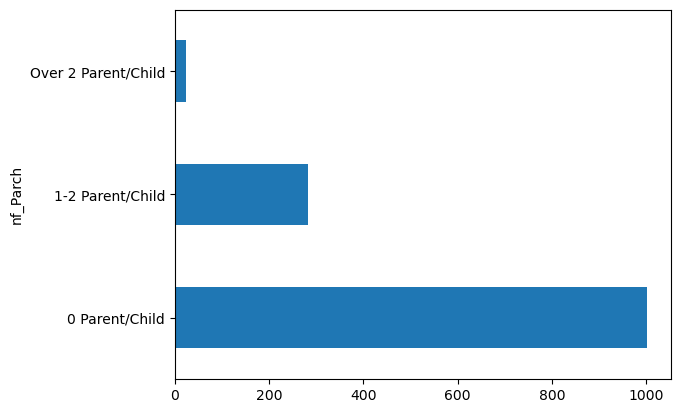

In [18]:
bins = [0, 1, 3, float('inf')]
labels = ['0 Parent/Child', '1-2 Parent/Child', 'Over 2 Parent/Child']

train_df['nf_Parch'] = pd.cut(train_df['Parch'], bins=bins, labels=labels, right=False)
test_df['nf_Parch'] = pd.cut(test_df['Parch'], bins=bins, labels=labels, right=False)
viewFull['nf_Parch'] = pd.cut(viewFull['Parch'], bins=bins, labels=labels, right=False)

print(viewFull.nf_Parch.value_counts(normalize=True))
viewFull.nf_Parch.value_counts().plot.barh()

nf_Parch             Survived
0 Parent/Child       0           0.656342
                     1           0.343658
1-2 Parent/Child     1           0.530303
                     0           0.469697
Over 2 Parent/Child  0           0.733333
                     1           0.266667
Name: proportion, dtype: float64


<Axes: xlabel='nf_Parch', ylabel='Survived'>

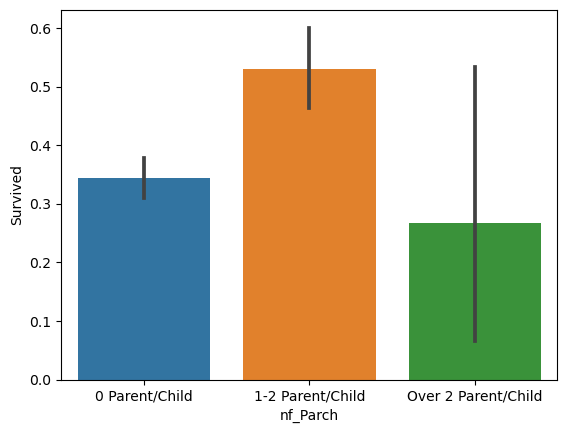

In [19]:
print(train_df.groupby("nf_Parch")["Survived"].value_counts(normalize=True))
sns.barplot(x="nf_Parch", y="Survived", data=train_df)

From the training data, we can see that:
* 34% of passengers that were by themselves survived. This means there is a high likelihood that if the passenger is by themselves, they won't survive.
* 53% of passengers that had 1 or 2 relations survived. A passenger having 1 or 2 relations doesn't seem to be an indicator of survivability on it's own. However due to all other options having lower survivabilities, you can say that these passengers have a higher likelihood of survivability.
* 26% of passengers that had more than 2 relations survived. This means there is an extemely high likelihood that if the passenger has more than 2 relations, they won't survive.

### Fare

<Axes: ylabel='Frequency'>

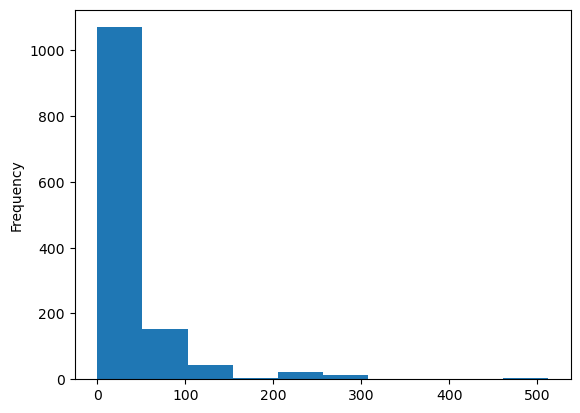

In [20]:
viewFull.Fare.sort_values().plot.hist()

The distribution of the passengers' fare is shown above (there's too many to list out individually).

The vast majority of passengers fare was under 100 (not sure which currency was used)

<Axes: xlabel='Fare', ylabel='Survived'>

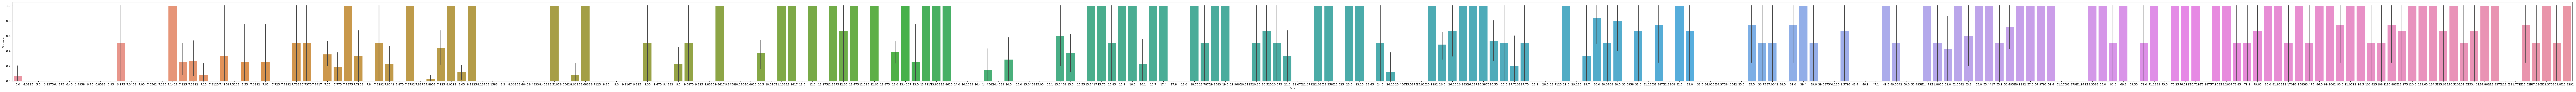

In [21]:
plt.figure(figsize=(160, 5))
sns.barplot(x="Fare", y="Survived", data=train_df)

I don't see any generalized differences between survivability based on fare. I also don't see the splits between classes.... Let's change that.

In [22]:
firstClass = viewFull[viewFull['Pclass'] == 1]
secondClass = viewFull[viewFull['Pclass'] == 2]
thirdClass = viewFull[viewFull['Pclass'] == 3]

#### First Class

Fare
26.5500     0.068111
27.7208     0.027864
52.0000     0.024768
26.0000     0.024768
262.3750    0.021672
              ...   
34.0208     0.003096
38.5000     0.003096
27.7500     0.003096
35.0000     0.003096
45.5000     0.003096
Name: proportion, Length: 107, dtype: float64


<Axes: ylabel='Frequency'>

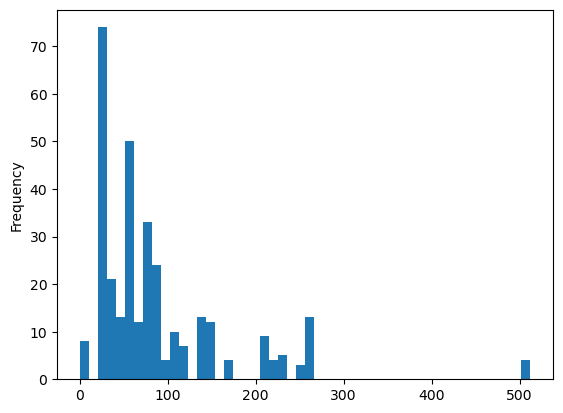

In [23]:
print(firstClass.Fare.value_counts(normalize=True))
firstClass.Fare.sort_values().plot.hist(bins=50)

It looks like first class passengers' Fare is typically around 26, but there's some spikes above it too. Those are probably for better accomodations.

nf_Fare
26-100    0.708333
100+      0.245370
<26       0.046296
Name: proportion, dtype: float64


/tmp/ipykernel_30862/1165569020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstClassTrain['nf_Fare'] = pd.cut(firstClassTrain['Fare'], bins=bins, labels=labels, right=False)


<Axes: ylabel='nf_Fare'>

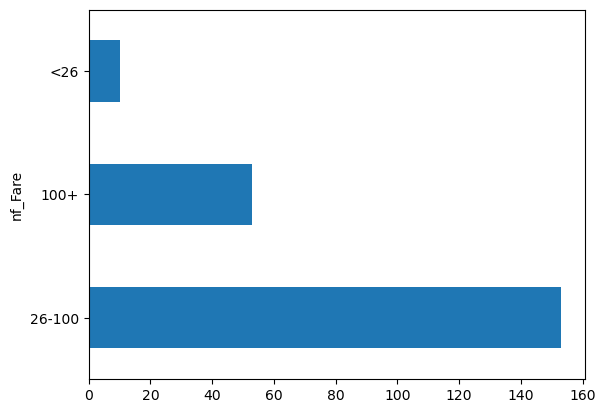

In [24]:
bins = [0, 26, 100.001, float('inf')]
labels = ['<26', '26-100', '100+']

firstClassTrain = train_df[train_df['Pclass'] == 1]
firstClassTrain['nf_Fare'] = pd.cut(firstClassTrain['Fare'], bins=bins, labels=labels, right=False)


print(firstClassTrain.nf_Fare.value_counts(normalize=True))
firstClassTrain.nf_Fare.value_counts().plot.barh()

nf_Fare  Survived
<26      0           0.800000
         1           0.200000
26-100   1           0.620915
         0           0.379085
100+     1           0.735849
         0           0.264151
Name: proportion, dtype: float64


<Axes: xlabel='nf_Fare', ylabel='Survived'>

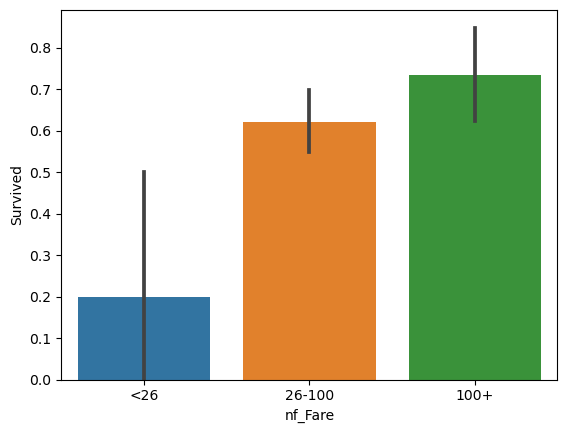

In [25]:
print(firstClassTrain.groupby("nf_Fare")["Survived"].value_counts(normalize=True))
sns.barplot(x="nf_Fare", y="Survived", data=firstClassTrain)

#### Second Class

Fare
13.0000    0.212996
26.0000    0.151625
10.5000    0.126354
21.0000    0.050542
13.5000    0.025271
73.5000    0.025271
23.0000    0.025271
39.0000    0.025271
0.0000     0.021661
11.5000    0.021661
26.2500    0.021661
65.0000    0.018051
12.3500    0.018051
27.7500    0.014440
41.5792    0.014440
36.7500    0.014440
31.5000    0.010830
13.8583    0.010830
37.0042    0.010830
15.0458    0.010830
29.0000    0.010830
33.0000    0.010830
32.5000    0.010830
18.7500    0.010830
27.7208    0.007220
30.0000    0.007220
13.8625    0.007220
30.0708    0.007220
15.7500    0.007220
12.8750    0.007220
16.0000    0.007220
19.5000    0.007220
14.5000    0.007220
24.0000    0.007220
27.0000    0.007220
14.0000    0.003610
10.7083    0.003610
15.5792    0.003610
15.0333    0.003610
12.5250    0.003610
9.6875     0.003610
12.2750    0.003610
15.0500    0.003610
15.0000    0.003610
13.7917    0.003610
12.6500    0.003610
12.0000    0.003610
12.7375    0.003610
Name: proportion, dtype: float64


<Axes: ylabel='Frequency'>

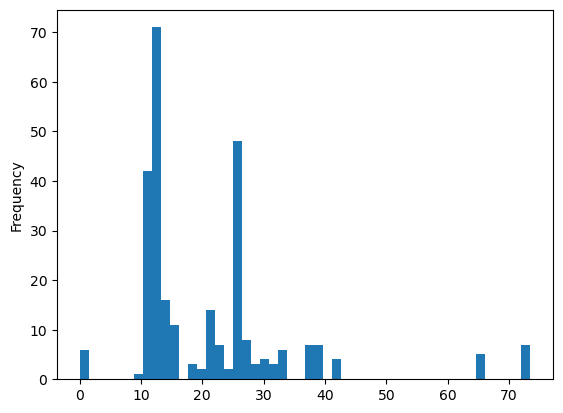

In [26]:
print(secondClass.Fare.value_counts(normalize=True))
secondClass.Fare.sort_values().plot.hist(bins=50)

It looks like second class passengers's Fare is around 13. There also some spikes above it too. Those are probably for better accomodations.

nf_Fare
10-16    0.500000
16+      0.467391
<10      0.032609
Name: proportion, dtype: float64


/tmp/ipykernel_30862/2638665813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondClassTrain['nf_Fare'] = pd.cut(secondClassTrain['Fare'], bins=bins, labels=labels, right=False)


<Axes: ylabel='nf_Fare'>

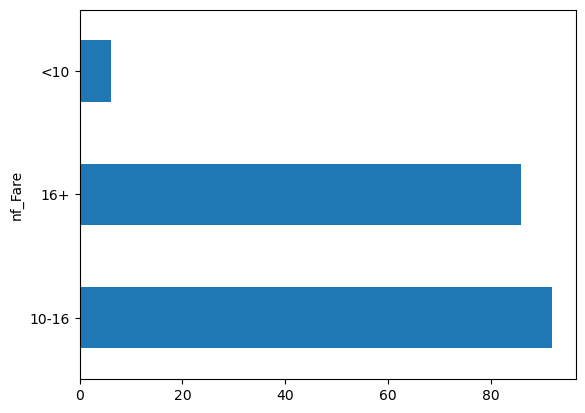

In [27]:
bins = [0, 10, 16, float('inf')]
labels = ['<10', '10-16', '16+']

secondClassTrain = train_df[train_df['Pclass'] == 2]
secondClassTrain['nf_Fare'] = pd.cut(secondClassTrain['Fare'], bins=bins, labels=labels, right=False)


print(secondClassTrain.nf_Fare.value_counts(normalize=True))
secondClassTrain.nf_Fare.value_counts().plot.barh()

nf_Fare  Survived
<10      0           1.000000
         1           0.000000
10-16    0           0.608696
         1           0.391304
16+      1           0.593023
         0           0.406977
Name: proportion, dtype: float64


<Axes: xlabel='nf_Fare', ylabel='Survived'>

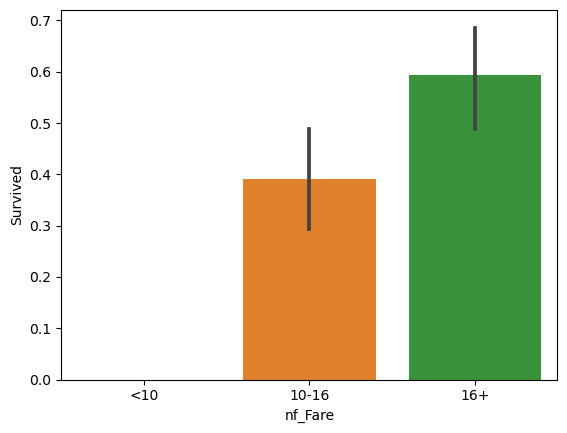

In [28]:
print(secondClassTrain.groupby("nf_Fare")["Survived"].value_counts(normalize=True))
sns.barplot(x="nf_Fare", y="Survived", data=secondClassTrain)

#### Third Class

Fare
8.0500     0.084746
7.7500     0.077684
7.8958     0.069209
7.7750     0.036723
7.2292     0.033898
             ...   
8.4333     0.001412
9.8417     0.001412
8.1375     0.001412
10.1708    0.001412
7.7208     0.001412
Name: proportion, Length: 133, dtype: float64


<Axes: ylabel='Frequency'>

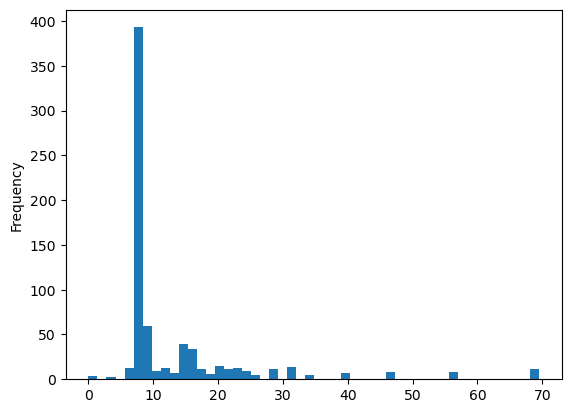

In [29]:
print(thirdClass.Fare.value_counts(normalize=True))
thirdClass.Fare.sort_values().plot.hist(bins=50)

It looks like third class passengers's Fare is around 8. There also some values above it, but they seem to be outliers.

nf_Fare
10-16    0.500000
16+      0.467391
<10      0.032609
Name: proportion, dtype: float64


/tmp/ipykernel_30862/1177041194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thirdClassTrain['nf_Fare'] = pd.cut(thirdClassTrain['Fare'], bins=bins, labels=labels, right=False)


<Axes: ylabel='nf_Fare'>

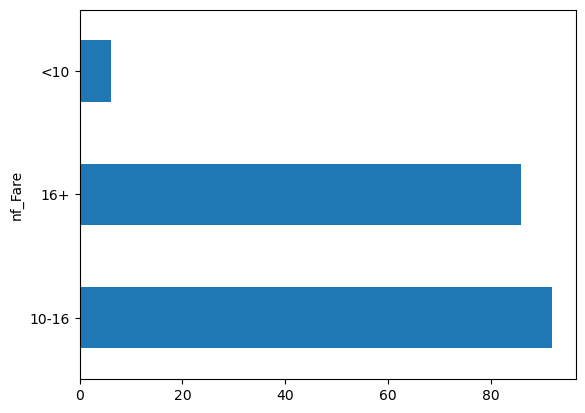

In [30]:
bins = [0, 10, 16, float('inf')]
labels = ['<10', '10-16', '16+']

thirdClassTrain = train_df[train_df['Pclass'] == 2]
thirdClassTrain['nf_Fare'] = pd.cut(thirdClassTrain['Fare'], bins=bins, labels=labels, right=False)


print(thirdClassTrain.nf_Fare.value_counts(normalize=True))
thirdClassTrain.nf_Fare.value_counts().plot.barh()

nf_Fare  Survived
<10      0           1.000000
         1           0.000000
10-16    0           0.608696
         1           0.391304
16+      1           0.593023
         0           0.406977
Name: proportion, dtype: float64


<Axes: xlabel='nf_Fare', ylabel='Survived'>

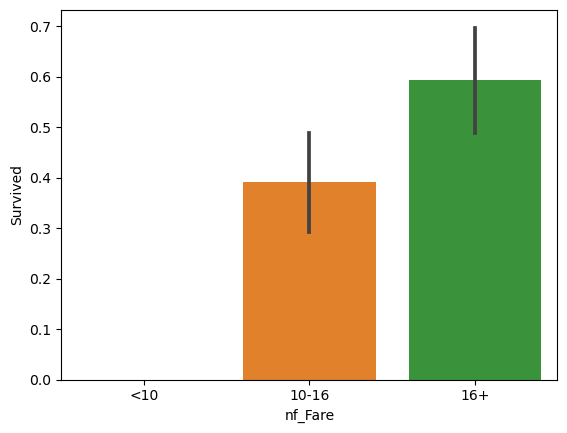

In [31]:
print(thirdClassTrain.groupby("nf_Fare")["Survived"].value_counts(normalize=True))
sns.barplot(x="nf_Fare", y="Survived", data=thirdClassTrain)

#### Overview
After taking a look at each class individually, I can see a clear increase in survivability when fare increases.

### Embarked

Embarked
S    0.699311
C    0.206580
Q    0.094109
Name: proportion, dtype: float64


<Axes: ylabel='Embarked'>

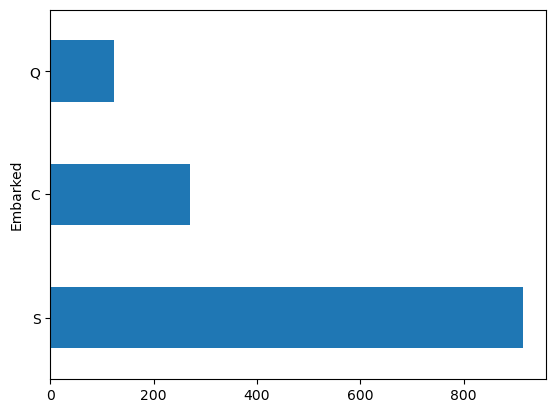

In [32]:
print(viewFull.Embarked.value_counts(normalize=True))
viewFull.Embarked.value_counts().plot.barh()

The distribution of the passengers' port of Embarkation is as follows:
* 69% were from Southampton (S)
* 20% were from Cherbourg (C)
* 9% were from Queenstown (Q)

Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: proportion, dtype: float64


<Axes: xlabel='Embarked', ylabel='Survived'>

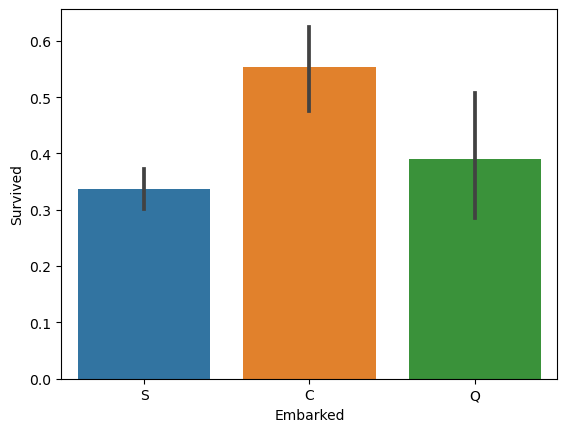

In [33]:
print(train_df.groupby("Embarked")["Survived"].value_counts(normalize=True))
sns.barplot(x="Embarked", y="Survived", data=train_df)

From the training data, we can see that:

* 33% of passengers from S survived.
* 55% of passengers from C survived.
* 38% of passengers from Q survived.

## Data Preprocessing

In [34]:
numeric_features = ["Fare"]
categorical_features = ["Pclass", "Sex", "Embarked", "nf_Age", "nf_SibSp", "nf_Parch"]
drop_features = ["PassengerId", "Name", "Age", "SibSp", "Parch", "Ticket", "Cabin"]

target = "Survived"

X_train = train_df.drop(columns=[target, *drop_features])
y_train = train_df[target]

X_test  = test_df.drop(columns=[*drop_features]) # test_df doesn't contain target

X_train

,Pclass,Sex,Fare,Embarked,nf_Age,nf_SibSp,nf_Parch
0,3,male,7.2500,S,Adult,1-2 Sib/Spouse,0 Parent/Child
1,1,female,71.2833,C,Adult,1-2 Sib/Spouse,0 Parent/Child
2,3,female,7.9250,S,Adult,0 Sib/Spouse,0 Parent/Child
3,1,female,53.1000,S,Adult,1-2 Sib/Spouse,0 Parent/Child
4,3,male,8.0500,S,Adult,0 Sib/Spouse,0 Parent/Child
...,...,...,...,...,...,...,...
886,2,male,13.0000,S,Adult,0 Sib/Spouse,0 Parent/Child
887,1,female,30.0000,S,Adult,0 Sib/Spouse,0 Parent/Child
888,3,female,23.4500,S,NaN,1-2 Sib/Spouse,1-2 Parent/Child
889,1,male,30.0000,C,Adult,0 Sib/Spouse,0 Parent/Child


In [35]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="mean"),
        StandardScaler()
        ), numeric_features
    ),
    (make_pipeline(
        SimpleImputer(fill_value=np.nan, strategy="most_frequent"),
        OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ), categorical_features
    ),
    remainder='passthrough'
)

## Training

In [36]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [37]:
results_dict = {}

models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for item in models:
    pipline = make_pipeline(preprocessor, models[item])

    results_dict[f"preprocessing w/ {item}"] = mean_std_cross_val_scores(pipline, X_train, y_train)

pd.DataFrame(results_dict)

,preprocessing w/ decision tree,preprocessing w/ kNN,preprocessing w/ RBF SVM
fit_time,0.016 (+/- 0.007),0.010 (+/- 0.002),0.022 (+/- 0.002)
score_time,0.007 (+/- 0.002),0.040 (+/- 0.012),0.007 (+/- 0.001)
test_score,0.814 (+/- 0.017),0.805 (+/- 0.066),0.824 (+/- 0.023)


In [38]:
if not exists("model.joblib"):
    model = make_pipeline(preprocessor, SVC())
    model.fit(X_train, y_train)
    dump(model, 'model.joblib')
else:
    model = load('model.joblib')

y_test = model.predict(X_test)

submission_df = pd.read_csv('./dataset/gender_submission.csv')
submission_df['Survived'] = y_test
submission_df.to_csv('submission.csv', index=False)
